<a href="https://colab.research.google.com/github/rcrcarissa/CSE5522/blob/main/CSE5522_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vowel Formants**

1.0: Set up the environment.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1.1: Load training and test data.

In [ ]:
TrainUrl = "https://raw.githubusercontent.com/rcrcarissa/CSE5522/main/vowelformants_train.csv"
TestUrl = "https://raw.githubusercontent.com/rcrcarissa/CSE5522/main/vowelformants_test.csv"
trainData = pd.read_csv(TrainUrl)
testData = pd.read_csv(TestUrl)

train_f1 = np.array(trainData['f1'],dtype='float')
train_f2 = np.array(trainData['f2'],dtype='float')
train_vowel = np.array(trainData['vowel'],dtype='str')
test_f1 = np.array(testData['f1'],dtype='float')
test_f2 = np.array(testData['f2'],dtype='float')
test_vowel = np.array(testData['vowel'],dtype='str')

num_train = len(train_vowel)
num_test = len(test_vowel)

1.2: Plot the vowel formants as 2-d scatterplots with a different color for each vowel for training and test data separately.  
We can see that dots in the same color are grouped by very similar spatial position, which implies that vowels can be differentiated by formants.

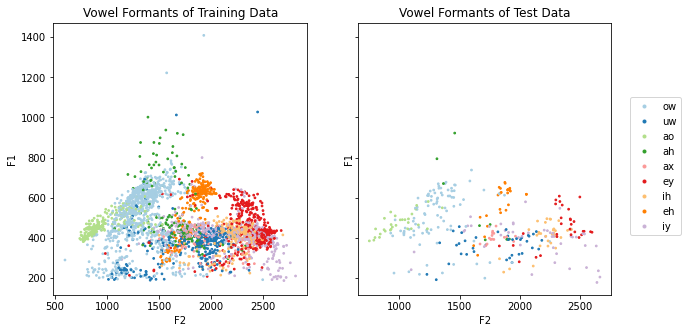

In [ ]:
# create "vowel-color" pairs
vowel_categories = np.array(list(set(np.concatenate((train_vowel, test_vowel), axis=0))))
num_vowels = len(vowel_categories)
int_map = dict(zip(vowel_categories, list(range(num_vowels))))
train_vowel_int = np.array([int_map[vowel] for vowel in train_vowel])
test_vowel_int = np.array([int_map[vowel] for vowel in test_vowel])
colormap = np.array(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6'])

# plot
fig, (train_plot, test_plot) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
train_plot.scatter(train_f2, train_f1, s=3, c=colormap[train_vowel_int])
train_plot.set_title('Vowel Formants of Training Data')
train_plot.set(xlabel='F2', ylabel='F1')
test_plot.scatter(test_f2, test_f1, s=3, c=colormap[test_vowel_int])
test_plot.set_title('Vowel Formants of Test Data')
test_plot.set(xlabel='F2', ylabel='F1')
patches = [plt.plot([],[], marker="o", ms=3, ls="", mec=None, color=colormap[i], label="{:s}".format(vowel_categories[i]))[0]  for i in range(len(vowel_categories))]
fig.legend(handles=patches, loc='right')
fig.show()

2.1: A Bayesian model that computes P(Vowel|Formants). Assumptions:  
P(Formants|Vowel) is 2-d diagonal covariance Gaussian distributed, which means that Formant 1 and formant 2 are conditionally independent given Vowel, i.e., P(Formants|Vowel) = P(Formant 1|Vowel) * P(Formant 2|Vowel).

In [ ]:
# P(Formants|Vowel)
mean_f1 = np.array([])
std_f1 = np.array([])
mean_f2 = np.array([])
std_f2 = np.array([])
for vowel in vowel_categories:
  train_f1_current_vowel = np.array([train_f1[i] for i in range(num_train) if train_vowel[i] == vowel])
  mean_f1 = np.append(mean_f1, np.mean(train_f1_current_vowel))
  std_f1 = np.append(std_f1, np.std(train_f1_current_vowel))
  train_f2_current_vowel = np.array([train_f2[i] for i in range(num_train) if train_vowel[i] == vowel])
  mean_f2 = np.append(mean_f2, np.mean(train_f2_current_vowel))
  std_f2 = np.append(std_f2, np.std(train_f2_current_vowel))

def OneDGaussian(x, mean, std):
  return np.exp(-((x - mean) / std) ** 2 / 2) / (std * np.sqrt(2 * np.pi))

def probFormantsGivenVowel(formants, vowel):
  mean1 = mean_f1[int_map[vowel]]
  std1 = std_f1[int_map[vowel]]
  gaussian1 = OneDGaussian(formants[0], mean1, std1)
  mean2 = mean_f2[int_map[vowel]]
  std2 = std_f2[int_map[vowel]]
  gaussian2 = OneDGaussian(formants[1], mean2, std2)
  return gaussian1 * gaussian2

# P(Vowel)
probVowel = np.array([])
for vowel in vowel_categories:
  probVowel = np.append(probVowel, np.count_nonzero(train_vowel == vowel))
probVowel /= num_train

# P(Vowel|Formants)
def probVowelGivenFormantsWithoutNorm(vowel, formants):
  return probFormantsGivenVowel(formants, vowel) * probVowel[int_map[vowel]]

def probVowelGivenFormants(vowel, formants):
  prob_without_norm = probVowelGivenFormantsWithoutNorm(vowel, formants)
  norm_factor = 0
  for v in vowel_categories:
    norm_factor += probVowelGivenFormantsWithoutNorm(v, formants)
  return prob_without_norm / norm_factor

# uncomment the line below to see a sample of P(Vowel='ey'|Formants=[1200,3000])
# print(probVowelGivenFormants('ey', [1200, 3000]))

2.2: Predict the most likely vowel for each test set token, and calculate the accuracy rate on the test set.

In [ ]:
def predictVowel(formants):
  prob = []
  for vowel in vowel_categories:
    prob.append(probVowelGivenFormants(vowel, formants))
  idx = prob.index(max(prob))
  return vowel_categories[idx]

predicted_vowels = np.array([])
for i in range(num_test):
  predicted_vowels = np.append(predicted_vowels, predictVowel([test_f1[i], test_f2[i]]))
accuracy_rate = np.count_nonzero(test_vowel == predicted_vowels) / num_test
print('Accuracy rate: ' + str(accuracy_rate))

Accuracy rate: 0.5617283950617284


3.1: Learn a mixture of Gaussians model of P(Formants|Vowel) for each vowel using the EM algorithm. Still assume that F1 and F2 are conditionally independent given vowel. The algorithm terminates when the change of parameters is sufficiently small (set to be less than 1e-8 here).  
* (1) The number of parameters in MoG when using *n* mixtures per vowel:  
  * (a) 9*n* classes in total;  
  * (b) 5 kinds of parameters for each class: class prior, mean of F1, standard deviation of F1, mean of F2, standard deviation of F2.  
So we have 45*n* parameters. If we compute parameters for 1, 2, 3, 4 mixtures per vowel, then we need 450 parameters.  
* (2) When using 1 mixture per vowel, the MoG model is the same as Bayesian model in Part 2.


In [ ]:
def EMAlgorithmForMOG(formants1, formants2, num_mixtures, eps):
  num_points = len(formants1)
  Pij = np.zeros([num_mixtures, num_points])  # P(C=i | Fj)
  update_changes = np.zeros(5)  # record whether the changes of parameters are less than eps

  # initialization
  class_prior = np.ones(num_mixtures) / num_mixtures
  means_f1 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.mean(formants1)
  stds_f1 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.std(formants1)
  means_f2 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.mean(formants2)
  stds_f2 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.std(formants2)

  while np.sum(update_changes) < len(update_changes):

    # record for comparison later
    previous_class_prior = class_prior
    previous_means_f1 = means_f1
    previous_means_f2 = means_f2
    previous_stds_f1 = stds_f1
    previous_stds_f2 = stds_f2

    # Expectation step
    for j in range(num_points):
      for i in range(num_mixtures):
        Pij[i, j] = OneDGaussian(formants1[j], means_f1[i], stds_f1[i]) * OneDGaussian(formants2[j], means_f2[i], stds_f2[i]) * class_prior[i]
      temp = Pij[:, j]
      temp /= sum(temp)
      Pij[:, j] = temp
    Ni = np.sum(Pij, axis=1) # effective number of data points currently assigned to Ci
    
    # Maximization step
    for i in range(num_mixtures):
      mean_f1_hat = np.sum(Pij[i, :] * formants1) / Ni[i]
      means_f1[i] = mean_f1_hat
      stds_f1[i] = np.sqrt(np.sum(Pij[i, :] * (formants1 - mean_f1_hat) ** 2) / Ni[i])
      mean_f2_hat = np.sum(Pij[i, :] * formants2) / Ni[i]
      means_f2[i] = mean_f2_hat
      stds_f2[i] = np.sqrt(np.sum(Pij[i, :] * (formants2 - mean_f2_hat) ** 2) / Ni[i])
    class_prior = Ni / num_points

    # compare difference of parameters in two epochs
    if np.sum(np.abs(previous_class_prior - class_prior) < eps) == num_mixtures:
      update_changes[0] = 1
    if np.sum(np.abs(previous_means_f1 - means_f1) < eps) == num_mixtures:
      update_changes[1] = 1
    if np.sum(np.abs(previous_means_f2 - means_f2) < eps) == num_mixtures:
      update_changes[2] = 1
    if np.sum(np.abs(previous_stds_f1 - stds_f1) < eps) == num_mixtures:
      update_changes[3] = 1
    if np.sum(np.abs(previous_stds_f2 - stds_f2) < eps) == num_mixtures:
      update_changes[4] = 1
  
  return class_prior, means_f1, stds_f1, means_f2, stds_f2


def distParametersGivenVowel(vowel, num_mixtures, eps):
  train_f1_current_vowel = np.array([train_f1[i] for i in range(num_train) if train_vowel[i] == vowel])
  train_f2_current_vowel = np.array([train_f2[i] for i in range(num_train) if train_vowel[i] == vowel])
  return EMAlgorithmForMOG(train_f1_current_vowel, train_f2_current_vowel, num_mixtures, eps)


def probFormantsGivenVowelEMWithoutNorm(formants, vowel, num_mixtures):
  class_prior = all_class_prior[num_mixtures][:, int_map[vowel]]
  means_f1 = all_means_f1[num_mixtures][:, int_map[vowel]]
  stds_f1 = all_stds_f1[num_mixtures][:, int_map[vowel]]
  means_f2 = all_means_f2[num_mixtures][:, int_map[vowel]]
  stds_f2 = all_stds_f2[num_mixtures][:, int_map[vowel]]
  # marginalize over mixtures
  mixed_gaussian = 0
  for i in range(num_mixtures):
    mixed_gaussian += OneDGaussian(formants[0], means_f1[i], stds_f1[i]) * OneDGaussian(formants[1], means_f2[i], stds_f2[i]) * class_prior[i]
  return mixed_gaussian


def probVowelGivenFormantsEMWithoutNorm(formants, vowel, num_mixtures):
  return probFormantsGivenVowelEMWithoutNorm(formants, vowel, num_mixtures) * probVowel[int_map[vowel]]


eps = 1e-8
# keep record of parameters for 1, 2, 3, 4 mixtures per vowel
all_class_prior = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_means_f1 = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_stds_f1 = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_means_f2 = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_stds_f2 = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
for num_mixtures in range(1, 5):
  for i in range(num_vowels):
    class_prior, means_f1, stds_f1, means_f2, stds_f2 = distParametersGivenVowel(vowel_categories[i], num_mixtures, eps)
    all_class_prior[num_mixtures][:, i] = class_prior
    all_means_f1[num_mixtures][:, i] = means_f1
    all_stds_f1[num_mixtures][:, i] = stds_f1
    all_means_f2[num_mixtures][:, i] = means_f2
    all_stds_f2[num_mixtures][:, i] = stds_f2

3.2: Predict vowels of test data and calculate the accuracy rates for using 1, 2, 3, 4 mixtures of Gaussians per vowel. We can see that:  
(1) The accuracy when using 1 mixture per vowel is the same as Part 2. Actually, this is because the models are the same.  
(2) The accuracy increases with number of mixtures per vowel increasing. This implies that P(Formats|Vowel) is not a simple Gaussian distribution.

In [ ]:
def predictVowelEM(formants, num_mixtures):
  prob = []
  for vowel in vowel_categories:
    prob.append(probVowelGivenFormantsEMWithoutNorm(formants, vowel, num_mixtures))
  idx = prob.index(max(prob))
  return vowel_categories[idx]


accuracy_rate = []
for num_mixtures in range(1, 5):
  predicted_vowels = np.array([])
  for i in range(num_test):
    predicted_vowels = np.append(predicted_vowels, predictVowelEM([test_f1[i], test_f2[i]], num_mixtures))
  accuracy_rate.append(np.count_nonzero(test_vowel == predicted_vowels) / num_test)
for i in range(4):
  print('Accuracy rate when ' + str(i + 1) + ' mixtures per vowel: ' + str(accuracy_rate[i]))

Accuracy rate when 1 mixtures per vowel: 0.5617283950617284
Accuracy rate when 2 mixtures per vowel: 0.6111111111111112
Accuracy rate when 3 mixtures per vowel: 0.6450617283950617
Accuracy rate when 4 mixtures per vowel: 0.654320987654321


4.1 (Bonus): Bayesian model (Part 2) using full-covariance Gaussians.  
The accuracy is a little higher than that using 2-d diagonal covariance Gaussian. This suggests that F1 and F2 are somewhat correlated. This correlation is also proven by the following code: we can see that for some vowels, the absolute values of correlation coefficents of F1 and F2 given the vowel are close to 1, but for some vowels F1 and F2 are weakly correlated since the correlation coefficents are nearly 0.

In [ ]:
# P(Formants|Vowel)
mean_f1 = np.array([])
std_f1 = np.array([])
mean_f2 = np.array([])
std_f2 = np.array([])
rho = np.array([])
for vowel in vowel_categories:
  train_f1_current_vowel = np.array([train_f1[i] for i in range(num_train) if train_vowel[i] == vowel])
  current_mean1 = np.mean(train_f1_current_vowel)
  mean_f1 = np.append(mean_f1, current_mean1)
  current_std1 = np.std(train_f1_current_vowel)
  std_f1 = np.append(std_f1, current_std1)
  train_f2_current_vowel = np.array([train_f2[i] for i in range(num_train) if train_vowel[i] == vowel])
  current_mean2 = np.mean(train_f2_current_vowel)
  mean_f2 = np.append(mean_f2, current_mean2)
  current_std2 = np.std(train_f2_current_vowel)
  std_f2 = np.append(std_f2, current_std2)
  co_var = np.mean((train_f1_current_vowel - current_mean1) * (train_f2_current_vowel - current_mean2))
  rho = np.append(rho, co_var / (current_std1 * current_std2))

# uncomment the lines below to see the correlation coefficent of F1 and F2 given vowel
print("correlation coefficent of F1 and F2 given vowel: " + str(rho))
print('\n')

def TwoDGaussian(x1, x2, mean1, mean2, std1, std2, co):
  v1 = x1 - mean1
  v2 = x2 - mean2
  exponent = -((v1 / std1) ** 2 - co * v1 * v2 / (std1 * std2) + (v2 / std2) ** 2)
  return np.exp(exponent) / (2 * np.pi * std1 * std2 * np.sqrt(1 - co ** 2))

def probFormantsGivenVowelFull(formants, vowel):
  mean1 = mean_f1[int_map[vowel]]
  std1 = std_f1[int_map[vowel]]
  mean2 = mean_f2[int_map[vowel]]
  std2 = std_f2[int_map[vowel]]
  correlation_co = rho[int_map[vowel]]
  return TwoDGaussian(formants[0], formants[1], mean1, mean2, std1, std2, correlation_co)

# P(Vowel|Formants)
def probVowelGivenFormantsWithoutNormFull(vowel, formants):
  return probFormantsGivenVowelFull(formants, vowel) * probVowel[int_map[vowel]]

def probVowelGivenFormantsFull(vowel, formants):
  prob_without_norm = probVowelGivenFormantsWithoutNormFull(vowel, formants)
  norm_factor = 0
  for v in vowel_categories:
    norm_factor += probVowelGivenFormantsWithoutNormFull(v, formants)
  return prob_without_norm / norm_factor

def predictVowelFull(formants):
  prob = []
  for vowel in vowel_categories:
    prob.append(probVowelGivenFormantsFull(vowel, formants))
  idx = prob.index(max(prob))
  return vowel_categories[idx]

predicted_vowels = np.array([])
for i in range(num_test):
  predicted_vowels = np.append(predicted_vowels, predictVowelFull([test_f1[i], test_f2[i]]))
accuracy_rate = np.count_nonzero(test_vowel == predicted_vowels) / num_test
print('Accuracy rate: ' + str(accuracy_rate))

correlation coefficent of F1 and F2 given vowel: [ 0.31074405  0.25401018  0.70973641 -0.52289237 -0.5007427   0.00573921
  0.32712157  0.86612628 -0.39247332]


Accuracy rate: 0.5802469135802469


4.2 (Bonus): Learn MoG model of full-covariance Gaussians using EM algorithm (Part 3). The accuracy rate does not increase with number of mixtures per vowel now; P(Formant|Vowel) for each vowel is best captured by MoG model with 2 mixture per vowel. The number of parameters increases largely with number of mixtures, but if we admit the dependence between F1 and F2, then the complexity of learning model is obviously and significantly reduced.

In [ ]:
def EMAlgorithmForMOGFull(formants1, formants2, num_mixtures, eps, initial_cor_co):
  num_points = len(formants1)
  Pij = np.zeros([num_mixtures, num_points])  # P(C=i | Fj)
  update_changes = np.zeros(6)  # record whether the changes of parameters are less than eps

  # initialization
  class_prior = np.ones(num_mixtures) / num_mixtures
  means_f1 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.mean(formants1)
  stds_f1 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.std(formants1)
  means_f2 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.mean(formants2)
  stds_f2 = ((np.random.ranf(num_mixtures) - 0.5) * 0.2 + 1) * np.std(formants2)
  cor_co = np.ones(num_mixtures) * initial_cor_co

  while np.sum(update_changes) < len(update_changes):

    # record for comparison later
    previous_class_prior = class_prior
    previous_means_f1 = means_f1
    previous_means_f2 = means_f2
    previous_stds_f1 = stds_f1
    previous_stds_f2 = stds_f2
    previous_cor_co = cor_co

    # Expectation step
    for j in range(num_points):
      for i in range(num_mixtures):
        Pij[i, j] = TwoDGaussian(formants1[j], formants2[j], means_f1[i], means_f2[i], stds_f1[i], stds_f2[i], cor_co[i]) * class_prior[i]
      temp = Pij[:, j]
      temp /= sum(temp)
      Pij[:, j] = temp
    Ni = np.sum(Pij, axis=1) # effective number of data points currently assigned to Ci
    
    # Maximization step
    for i in range(num_mixtures):
      mean_f1_hat = np.sum(Pij[i, :] * formants1) / Ni[i]
      means_f1[i] = mean_f1_hat
      std_f1_hat = np.sqrt(np.sum(Pij[i, :] * (formants1 - mean_f1_hat) ** 2) / Ni[i])
      stds_f1[i] = std_f1_hat
      mean_f2_hat = np.sum(Pij[i, :] * formants2) / Ni[i]
      means_f2[i] = mean_f2_hat
      std_f2_hat = np.sqrt(np.sum(Pij[i, :] * (formants2 - mean_f2_hat) ** 2) / Ni[i])
      stds_f2[i] = std_f2_hat
      cov_hat = np.sum(Pij[i, :] * (formants1 - mean_f1_hat) * (formants2 - mean_f2_hat)) / Ni[i]
      cor_co[i] = cov_hat / (std_f1_hat * std_f2_hat)
    class_prior = Ni / num_points

    # compare difference of parameters in two epochs
    if np.sum(np.abs(previous_class_prior - class_prior) < eps) == num_mixtures:
      update_changes[0] = 1
    if np.sum(np.abs(previous_means_f1 - means_f1) < eps) == num_mixtures:
      update_changes[1] = 1
    if np.sum(np.abs(previous_means_f2 - means_f2) < eps) == num_mixtures:
      update_changes[2] = 1
    if np.sum(np.abs(previous_stds_f1 - stds_f1) < eps) == num_mixtures:
      update_changes[3] = 1
    if np.sum(np.abs(previous_stds_f2 - stds_f2) < eps) == num_mixtures:
      update_changes[4] = 1
    if np.sum(np.abs(previous_cor_co - cor_co) < eps) == num_mixtures:
      update_changes[5] = 1
  
  return class_prior, means_f1, stds_f1, means_f2, stds_f2, cor_co


def distParametersGivenVowelFull(vowel, num_mixtures, eps):
  train_f1_current_vowel = np.array([train_f1[i] for i in range(num_train) if train_vowel[i] == vowel])
  train_f2_current_vowel = np.array([train_f2[i] for i in range(num_train) if train_vowel[i] == vowel])
  initial_cor_co = rho[int_map[vowel]]
  return EMAlgorithmForMOGFull(train_f1_current_vowel, train_f2_current_vowel, num_mixtures, eps, initial_cor_co)


def probFormantsGivenVowelEMWithoutNormFull(formants, vowel, num_mixture):
  class_prior = all_class_prior_full[num_mixtures][:, int_map[vowel]]
  means_f1 = all_means_f1_full[num_mixtures][:, int_map[vowel]]
  stds_f1 = all_stds_f1_full[num_mixtures][:, int_map[vowel]]
  means_f2 = all_means_f2_full[num_mixtures][:, int_map[vowel]]
  stds_f2 = all_stds_f2_full[num_mixtures][:, int_map[vowel]]
  cor_co = all_cor_co_full[num_mixtures][:, int_map[vowel]]

  # marginalize over mixtures
  mixed_gaussian = 0
  for i in range(num_mixtures):
    mixed_gaussian += TwoDGaussian(formants[0], formants[1], means_f1[i], means_f2[i], stds_f1[i], stds_f2[i], cor_co[i]) * class_prior[i]
  return mixed_gaussian


def probVowelGivenFormantsEMWithoutNormFull(formants, vowel, num_mixtures):
  return probFormantsGivenVowelEMWithoutNormFull(formants, vowel, num_mixtures) * probVowel[int_map[vowel]]


def predictVowelEMFull(formants, num_mixtures):
  prob = []
  for vowel in vowel_categories:
    prob.append(probVowelGivenFormantsEMWithoutNormFull(formants, vowel, num_mixtures))
  idx = prob.index(max(prob))
  return vowel_categories[idx]

eps = 1e-2
# keep record of parameters for 1, 2, 3, 4 mixtures per vowel
all_class_prior_full = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_means_f1_full = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_stds_f1_full = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_means_f2_full = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_stds_f2_full = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
all_cor_co_full = {1: np.zeros([1, num_vowels]), 2: np.zeros([2, num_vowels]), 3: np.zeros([3, num_vowels]), 4: np.zeros([4, num_vowels])}
for num_mixtures in range(1, 5):
  for i in range(num_vowels):
    class_prior, means_f1, stds_f1, means_f2, stds_f2, cor_co = distParametersGivenVowelFull(vowel_categories[i], num_mixtures, eps)
    all_class_prior_full[num_mixtures][:, i] = class_prior
    all_means_f1_full[num_mixtures][:, i] = means_f1
    all_stds_f1_full[num_mixtures][:, i] = stds_f1
    all_means_f2_full[num_mixtures][:, i] = means_f2
    all_stds_f2_full[num_mixtures][:, i] = stds_f2
    all_cor_co_full[num_mixtures][:, i] = cor_co

accuracy_rate = []
for num_mixtures in range(1, 5):
  predicted_vowels = np.array([])
  for i in range(num_test):
    predicted_vowels = np.append(predicted_vowels, predictVowelEMFull([test_f1[i], test_f2[i]], num_mixtures))
  accuracy_rate.append(np.count_nonzero(test_vowel == predicted_vowels) / num_test)
for i in range(4):
  print('Accuracy rate when ' + str(i + 1) + ' mixtures per vowel: ' + str(accuracy_rate[i]))

Accuracy rate when 1 mixtures per vowel: 0.5802469135802469
Accuracy rate when 2 mixtures per vowel: 0.6172839506172839
Accuracy rate when 3 mixtures per vowel: 0.6018518518518519
Accuracy rate when 4 mixtures per vowel: 0.595679012345679
